### General rules:
 * Replace *Template* by your *FirstnameLastname* in the filename before submitting the solution.
 * For all figures that you generate, remember to add meaningful labels to the axes, and make a legend, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.

# AAND - BCI Exercise Sheet #01

#### Name: MartinIniguezdeOnzono

In [2]:
# This is just a suggestion. You can do it your way.

%matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Load the data set

In [1]:
fname= 'eyes_closed_VPal.npz'
X, fs, clab, mnt = bci.load_data(fname)

NameError: name 'bci' is not defined

## Exercise 1: PCA on raw data  (2 points)
Make a scatter plot using the channels Fz and Oz. Visualize the complete covariance matrix (functions `np.cov` and `pl.imshow`). Then determine the two principle components (Eigenvectors) (function `np.linalg.eigh`) of that data that correspond to the largest Eigenvalues and display them as scalp maps (function `scalpmap` provided in the `bci_minitoolbox`).

In [3]:
def PC_sort(data):
    cov = np.cov(data)
    eig_val, eig_vec = np.linalg.eig(cov)
    idx = np.argsort(eig_val, axis = 0)[::-1]
    sorted_PC = eig_vec[:,idx].T
    return sorted_PC

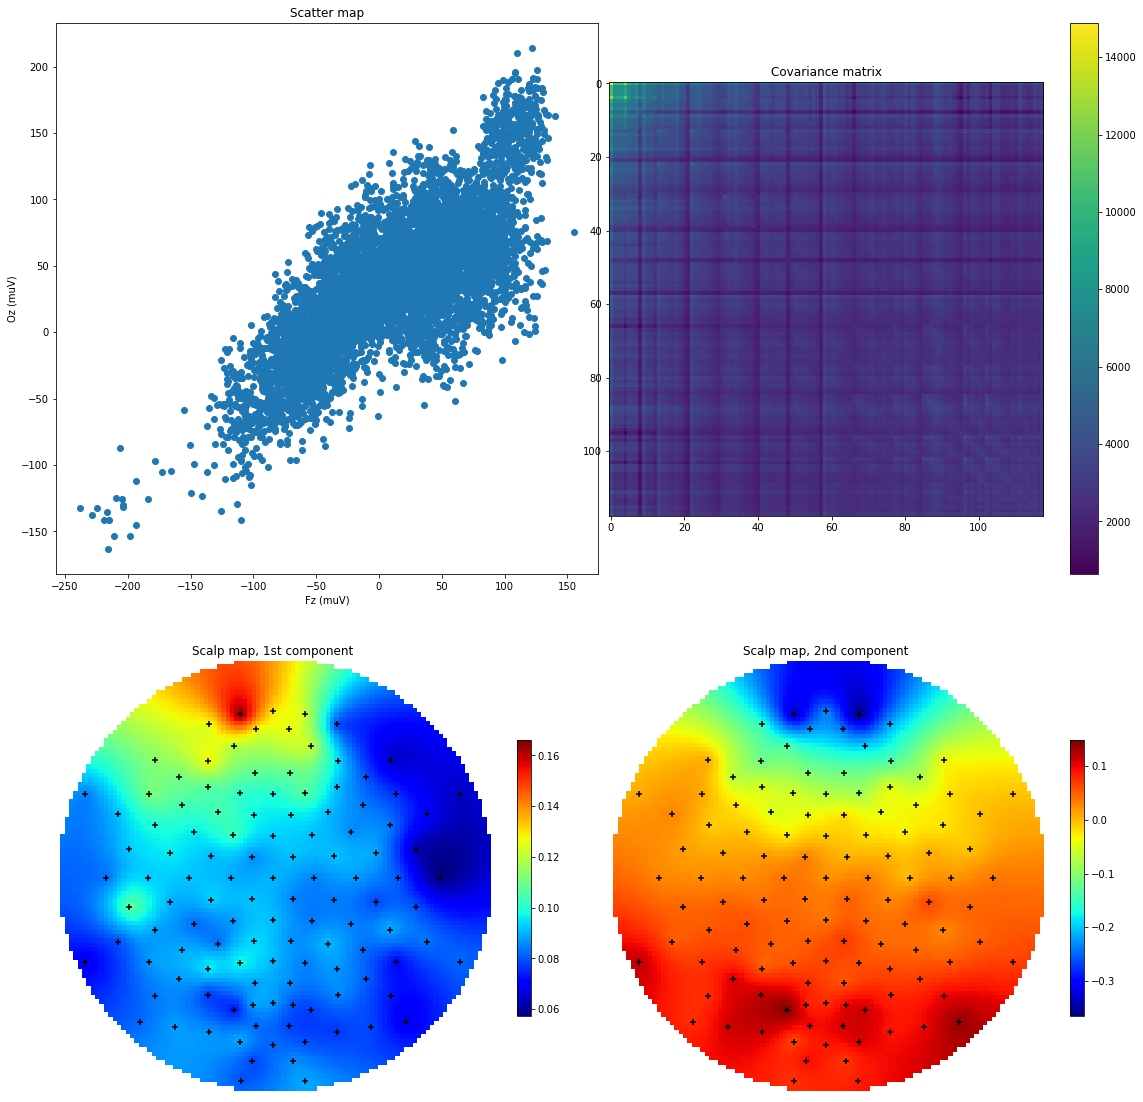

In [4]:
matches = []
num = -1

for match in clab:
    num +=1
    if "Fz" in match:
        Fz_pos = num
    if "Oz" in match:
        Oz_pos = num

Fz = X[Fz_pos]
Oz = X[Oz_pos]

fig=plt.figure(figsize=(16,16))
fig.add_subplot(221)
plt.scatter(Fz,Oz)
plt.tight_layout()
plt.xlabel('Fz (muV)')
plt.ylabel('Oz (muV)');
plt.title('Scatter map')


fig.add_subplot(222)
cov_mat = np.cov(X)
plt.imshow(cov_mat)
plt.colorbar()
plt.title('Covariance matrix');


fig.add_subplot(223)
eigvec = PC_sort(X)
bci.scalpmap(mnt,-eigvec[0])
plt.title('Scalp map, 1st component')

fig.add_subplot(224)
plt.title('Scalp map, 2nd component')
bci.scalpmap(mnt,-eigvec[1])

## Exercise 2: Artifact Correction with PCA  (3 points)
Using the backward model, estimate the source activity corresponding to the two components that were found in Ex. \#01 and plot the two obtained time series. Using the forward model, estimate that part of the measured EEG signals, that originates from these two sources. Subtract this multivariate signal from the original EEG. Compare the thus obtained cleaned signal in channel Fz with the original data.

In [5]:
def MSE(x,y):
    n = len(x)
    value = np.sum((x-y)**2)/n
    return value

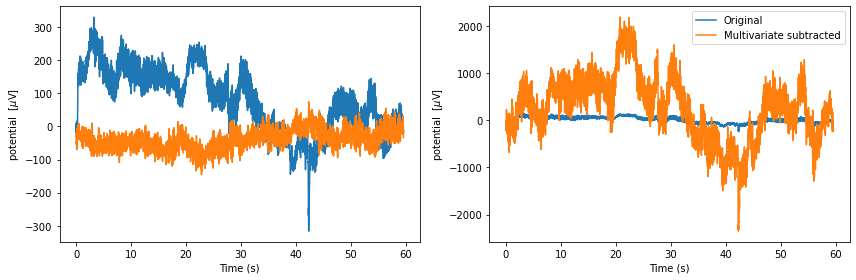

In [6]:
s = eigvec.T @ X
t = np.arange(0,len(Oz)/fs,1/fs)

estimate = eigvec @ X

fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.plot(t,s[0])
plt.plot(t,s[1])

plt.xlabel('Time (s)')
plt.ylabel('potential  [$\mu$V]')


fig.add_subplot(122)

subst_multi = X-estimate[0]-estimate[1]
plt.plot(t,Fz,label='Original')
plt.plot(t,subst_multi[Fz_pos],label='Multivariate subtracted')
plt.legend()

plt.xlabel('Time (s)')
plt.ylabel('potential  [$\mu$V]')
plt.tight_layout()

## Exercise 3: PCA on band-pass filtered data (3 points)
Design a butterworth band-pass filter of order 10 with the frequency band 8-12 Hz (function `sp.signal.butter`). Apply that band-pass filter to the original EEG signals (function `sp.signal.lfilter`) and compare raw and filtered signals for channel Oz.
Visualize the covariance matrix of the filtered data and check the eigenvalue spectrum, to determine how many strong principal components there are. Visualize those principal components as in Ex. \#01. Compare the results and discuss shortly.

In [7]:
def PC_allsort(data):
    cov = np.cov(data)
    eig_val, eig_vec = np.linalg.eig(cov)
    idx = np.argsort(eig_val, axis = 0)[::-1]
    sorted_PC = eig_vec[:,idx].T
    return sorted_PC,eig_val[idx],idx,cov

In [8]:
def butter_bandpass(lowcut, highcut, fs, order=10):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sp.signal.butter(order, [low, high], btype='band')
    return b, a

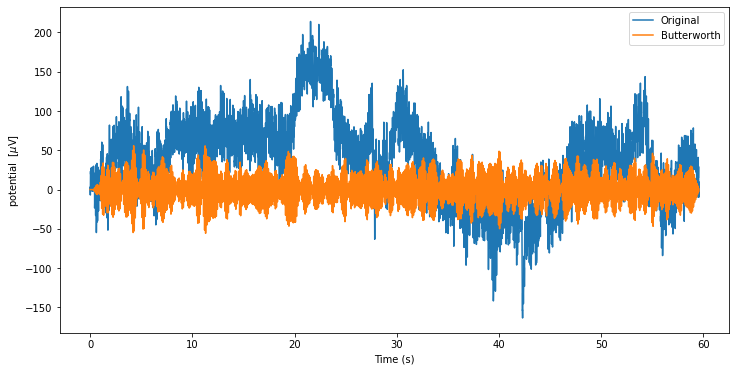

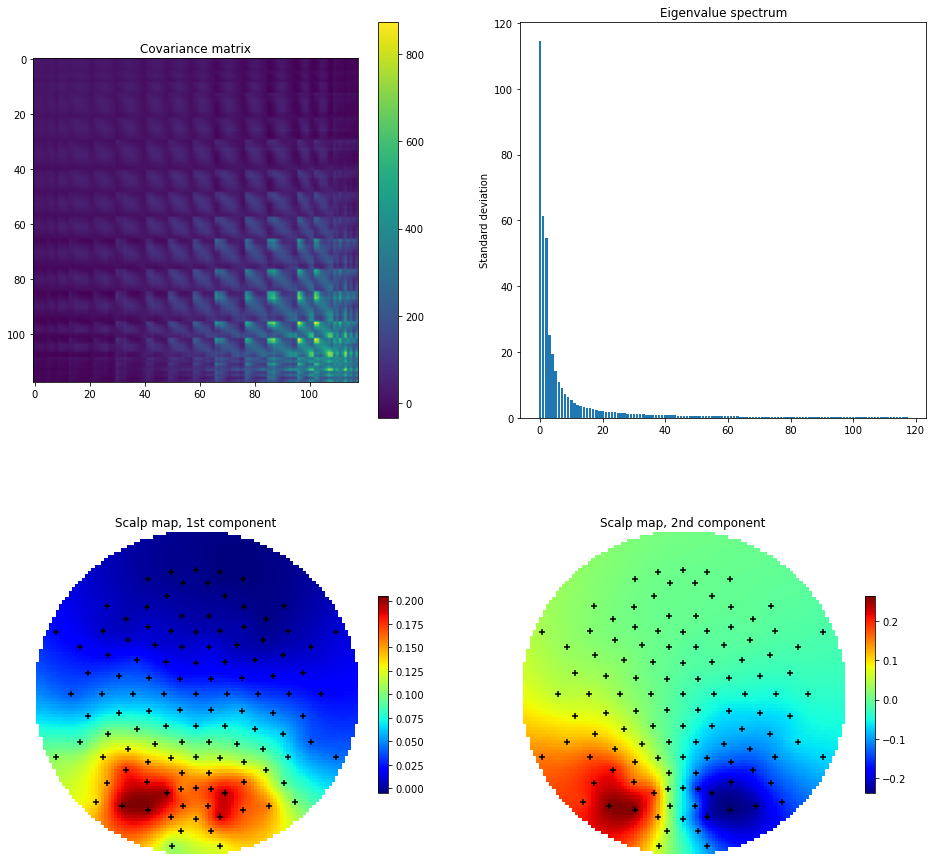

In [9]:
b,a = butter_bandpass(8,12,fs)
X_butter = sp.signal.lfilter(b,a,X)

eig_vec,eig_val,idx,cov = PC_allsort(X_butter)

fig=plt.figure(figsize=(12,6))
plt.plot(t,Oz,label='Original')
plt.plot(t,X_butter[Oz_pos],label='Butterworth')
plt.legend()
plt.ylabel('potential  [$\mu$V]')
plt.xlabel('Time (s)')

fig=plt.figure(figsize=(16,16))

fig.add_subplot(221)
plt.imshow(cov)
plt.colorbar()
plt.title('Covariance matrix');

fig.add_subplot(222)
plt.bar(idx,np.sqrt(eig_val))
plt.title('Eigenvalue spectrum')
plt.ylabel('Standard deviation')

fig.add_subplot(223)
eigvec = PC_sort(X)
bci.scalpmap(mnt,eig_vec[0])
plt.title('Scalp map, 1st component')

fig.add_subplot(224)
plt.title('Scalp map, 2nd component')
bci.scalpmap(mnt,eig_vec[1]);

### Compare the results and discuss shortly.

## Exercise 4: Reconstruction with few PCs  (2 points)
Calculate the signals corresponding to the strongest principal components (second part of Ex. \#03) of the filtered data (project EEG data onto the PCs, i.e. go from *sensor space* to *source space*). Then reconstruct the EEG data from those strong principal components, i.e. project the signals obtained in the first step back into *sensor space*. Compare the band-pass filtered signal with the reconstructed signal in channel Oz. For plotting, the first six seconds are enough. You can also apply an error measure on your choice.

The Mean Square Error is: 4600.463628759965


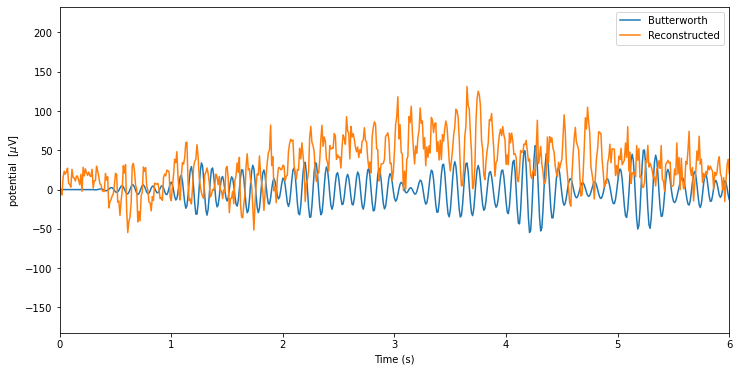

In [10]:


proj = eig_vec @ X
back_proj = eig_vec.T @ proj

fig=plt.figure(figsize=(12,6))
plt.plot(t,X_butter[Oz_pos],label='Butterworth')
plt.plot(t,back_proj[Oz_pos],label='Reconstructed');
plt.legend()
plt.ylabel('potential  [$\mu$V]')
plt.xlabel('Time (s)')
plt.xlim([0,6])

MSE_VAL = MSE(X_butter[Oz_pos],back_proj[Oz_pos])

print("The Mean Square Error is: " + str(MSE_VAL))